In [5]:
%%capture
# ---------------------------------------------------------------------------- #
#                        DETAILS TECHNIQUES DU NOTEBOOK                        #
# ---------------------------------------------------------------------------- #

%load_ext autoreload
%autoreload 2

import sys
import os

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..', 'src', "tensorflow")))

# Remove tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Description

Ce notebook présente une première approche des **Gradients Intégrés** avec *Tensorflow*. Nous y suivons le tutoriel disponible ici : https://www.tensorflow.org/tutorials/interpretability/integrated_gradients?hl=fr

Il ne s'agit ni plus ni moins qu'une réimplémentation de ce tutoriel, avec quelques explorations & remarques personnelles

## Chargement & Entrainement du modèle

In [6]:
# ---------------------------------------------------------------------------- #
#                             CHARGEMENT DU MODELE                             #
# ---------------------------------------------------------------------------- #
from Model import Model

model = Model().summary()

INFO:Model:Downloading pretrained model: inception_v1
INFO:Model:Downloading imagenet labels...
INFO:Model:Model summary:


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v1 (KerasLayer)   (None, 1001)              6633209   
                                                                 
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


INFO:Model:Loading images...
INFO:Model:Displaying images...


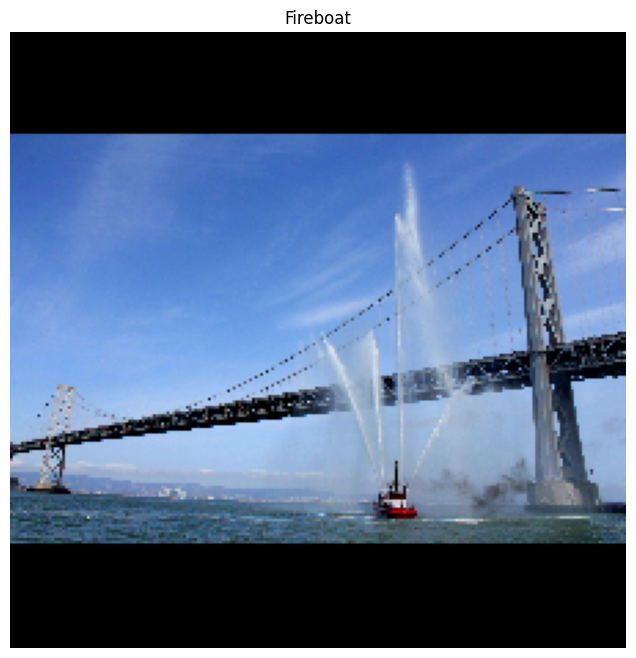

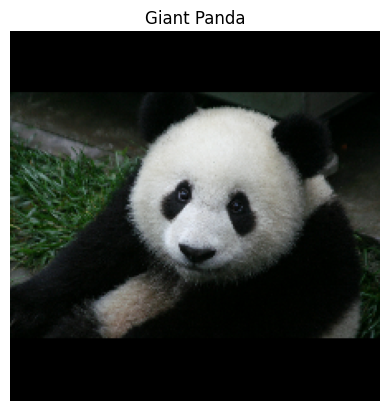

In [7]:
# ---------------------------------------------------------------------------- #
#                             CHARGEMENT DES IMAGES                            #
# ---------------------------------------------------------------------------- #

model = model.load_images({
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}, display=True)

INFO:Model:Predicting images classes...
INFO:Model:Displaying predictions...


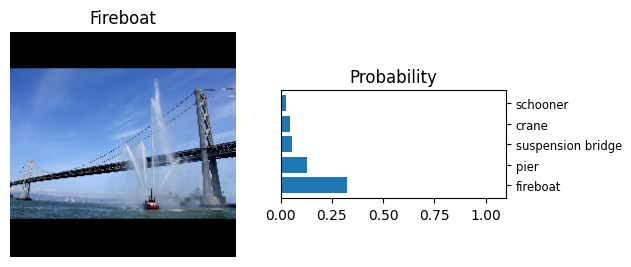

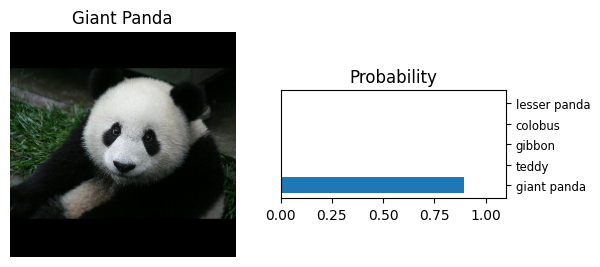

In [15]:
model.predict(display=True)